In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer,randint
import bayes_opt 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,matthews_corrcoef
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder

In [3]:
d = pd.read_csv('hiring_dataset_100k_optimized.csv')
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Gender           100000 non-null  object
 1   Age              100000 non-null  int64 
 2   Experience       100000 non-null  int64 
 3   Education Level  100000 non-null  object
 4   Test Score       100000 non-null  int64 
 5   Selected         100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [4]:
d["Education Level"].unique()

array(['Bachelor', 'Master', 'High School', 'Diploma', 'PhD'],
      dtype=object)

In [5]:
df_encoded = pd.get_dummies(d, columns=['Gender'],dtype=int)

In [6]:
encoder = OrdinalEncoder(categories=[['High School','Bachelor', 'Master', 'Diploma', 'PhD']])
df_encoded['Education Level'] = encoder.fit_transform(d[['Education Level']])
df_encoded.head(10)

,Age,Experience,Education Level,Test Score,Selected,Gender_Female,Gender_Male,Gender_Other
0,39,21,1.0,89,0,0,0,1
1,32,23,1.0,65,0,0,1,0
2,57,2,1.0,63,0,0,0,1
3,59,8,2.0,74,1,0,0,1
4,32,17,0.0,95,0,0,1,0
5,49,21,0.0,48,1,0,1,0
6,48,4,0.0,89,0,0,0,1
7,56,21,3.0,72,0,1,0,0
8,34,29,4.0,67,1,0,0,1
9,30,0,0.0,63,0,0,0,1


In [7]:
df_encoded.columns

Index(['Age', 'Experience', 'Education Level', 'Test Score', 'Selected',
       'Gender_Female', 'Gender_Male', 'Gender_Other'],
      dtype='object')

In [8]:
new_columns_oreder = ['Gender_Female', 'Gender_Male', 'Gender_Other','Age', 'Experience', 'Education Level', 'Test Score', 'Selected']
df_encoded = df_encoded[new_columns_oreder]

In [9]:
df_encoded

,Gender_Female,Gender_Male,Gender_Other,Age,Experience,Education Level,Test Score,Selected
0,0,0,1,39,21,1.0,89,0
1,0,1,0,32,23,1.0,65,0
2,0,0,1,57,2,1.0,63,0
3,0,0,1,59,8,2.0,74,1
4,0,1,0,32,17,0.0,95,0
...,...,...,...,...,...,...,...,...
99995,0,0,1,26,24,3.0,81,1
99996,0,0,1,41,24,0.0,83,0
99997,0,0,1,24,8,2.0,82,1
99998,0,0,1,35,3,3.0,57,0


In [10]:
scaler = StandardScaler()
df_encoded['Age_scaled'] = scaler.fit_transform(df_encoded[['Age']])
df_encoded['Test Score_scaled'] = scaler.fit_transform(df_encoded[['Test Score']])

In [11]:
new_columns_order = ['Gender_Female', 'Gender_Male', 'Gender_Other', 'Age_scaled', 'Experience', 
                     'Education Level', 'Test Score_scaled', 'Selected']
df_encoded = df_encoded[new_columns_order]

In [12]:
X = df_encoded.iloc[:, 0:-1].values  # Features
y = df_encoded.iloc[:, -1].values    # Target

In [16]:
X = df_encoded.iloc[:, 0:-1].values # Features (all columns except the target variable)
y = df_encoded.iloc[:, -1].values # Target variable
# Splitting the 80% of data into training and 20% of data into testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Hyperparameter Tunning 

## Logistic 

In [11]:
fi_range = [True, False]
solvers = ["newton-cg", "lbfgs"]
penalties = ["l2", None]

def objective(C, penalty):
    classifier = LogisticRegression(C=C,
                                    # fit_intercept=fi_range[1 if fit_intercept > 0.5 else 0],
                                    # solver=solvers[1 if solver > 0.5 else 0],
                                    penalty=penalties[1 if penalty > 0.5 else 0],
                                    max_iter=1000,
                                    random_state=123)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    "C": (0.5, 20),
    # "fit_intercept": (0, 1),
    # "solver": (0, 1),
    "penalty": (0, 1)
}

#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   |     C     |  penalty  |
-------------------------------------------------
| 1         | 0.6584    | 14.08     | 0.2861    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 2         | 0.6584    | 4.924     | 0.5513    |
| 3         | 0.6584    | 14.53     | 0.4231    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 4         | 0.6584    | 19.62     | 0.6848    |
| 5         | 0.6584    | 9.878     | 0.3921    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 6         | 0.6584    | 0.5013    | 0.7873    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 7         | 0.6584    | 0.5036    | 0.7892    |
| 8         | 0.6584    | 20.0      | 0.021     |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 9         | 0.6584    | 0.5004    | 0.9582    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 10        | 0.6584    | 20.0      | 0.9672    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 11        | 0.6584    | 14.6      | 0.6671    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 12        | 0.6584    | 1.138     | 0.7738    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 13        | 0.6584    | 8.773     | 0.5265    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 14        | 0.6584    | 11.73     | 0.5628    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 15        | 0.6584    | 13.64     | 0.9084    |
| 16        | 0.6584    | 10.51     | 0.2272    |
| 17        | 0.6584    | 0.5007    | 0.1013    |
| 18        | 0.6584    | 19.99     | 0.05646   |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 19        | 0.6584    | 0.5006    | 0.5431    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 20        | 0.6584    | 20.0      | 0.9661    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 21        | 0.6584    | 5.89      | 0.6725    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 22        | 0.6584    | 7.284     | 0.6734    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 23        | 0.6584    | 3.657     | 0.9098    |
| 24        | 0.6584    | 4.353     | 0.2238    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 25        | 0.6584    | 20.0      | 0.867     |
| 26        | 0.6584    | 19.99     | 0.06757   |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 27        | 0.6584    | 0.673     | 0.8613    |
| 28        | 0.6584    | 19.58     | 0.0773    |


D:\Installations\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


| 29        | 0.6584    | 9.299     | 0.505     |
| 30        | 0.6584    | 14.77     | 0.07086   |


In [12]:
C = optimizer.max["params"]["C"]
# fit_intercept = fi_range[1 if optimizer.max["params"]["fit_intercept"] > 0.5 else 0]
# solver = solvers[1 if optimizer.max["params"]["solver"] > 0.5 else 0]
penalty = penalties[1 if optimizer.max["params"]["penalty"] > 0.5 else 0]

print("Best Parameter Setting : {}".format({"C": C, "penalty":penalty}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'C': 14.081149119158303, 'penalty': 'l2'}
Best Accuracy          : 0.66


In [13]:
LR_clf1 = LogisticRegression(C = 14.081149119158303, penalty = "l2",random_state = 0,max_iter=1000)
LR_clf1.fit(X_train, y_train)
y_pred = LR_clf1.predict(X_test)
print("Accuracy of Logistic Regression : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of Logistic Regression :  0.6584
[[12927   238]
 [ 6594   241]]
0.6584
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     13165
           1       0.50      0.04      0.07      6835

    accuracy                           0.66     20000
   macro avg       0.58      0.51      0.43     20000
weighted avg       0.61      0.66      0.54     20000

0.05329921870346099


## SVC

In [14]:
kernels= ['rbf', 'sigmoid']
gammas = ["scale", "auto"]

def objective(C, kernel, degree, gamma):
    classifier = SVC(C=C,
                     kernel=kernels[1 if kernel > 0.5 else 0],
                     degree=int(degree),
                     gamma=gamma,
                     max_iter=1000,
                     random_state=123)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    "C": (0.5,20),
    "kernel": (0,1),
    "degree": (0, 20),
    "gamma": (0.01,0.1)
    
}

#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   |     C     |  degree   |   gamma   |  kernel   |
-------------------------------------------------------------------------


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 1         | 0.3417    | 14.08     | 5.723     | 0.03042   | 0.5513    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 2         | 0.6583    | 14.53     | 8.462     | 0.09827   | 0.6848    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 3         | 0.3417    | 9.878     | 7.842     | 0.04089   | 0.729     |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 4         | 0.3417    | 9.052     | 1.194     | 0.04582   | 0.738     |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 5         | 0.3417    | 4.059     | 3.509     | 0.05784   | 0.5318    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 6         | 0.6452    | 3.328     | 8.509     | 0.01284   | 0.429     |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 7         | 0.6197    | 17.49     | 4.353     | 0.09718   | 0.4987    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 8         | 0.6583    | 12.46     | 15.16     | 0.05494   | 0.9653    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 9         | 0.3417    | 6.75      | 6.871     | 0.03343   | 0.7113    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 10        | 0.3417    | 5.014     | 3.25      | 0.07162   | 0.7381    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 11        | 0.6583    | 14.94     | 10.05     | 0.1       | 0.753     |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 12        | 0.3417    | 17.76     | 8.305     | 0.1       | 0.6963    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 13        | 0.6056    | 13.41     | 9.81      | 0.03947   | 0.1507    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 14        | 0.6583    | 13.8      | 13.12     | 0.1       | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 15        | 0.5794    | 14.99     | 15.43     | 0.01      | 0.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 16        | 0.646     | 1.383     | 10.37     | 0.01      | 0.2737    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 17        | 0.6171    | 19.26     | 1.875     | 0.1       | 0.3852    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 18        | 0.6583    | 4.003     | 11.83     | 0.01      | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 19        | 0.3417    | 8.444     | 14.82     | 0.1       | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 20        | 0.3417    | 1.413     | 13.74     | 0.1       | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 21        | 0.3417    | 0.5436    | 7.982     | 0.07416   | 0.7136    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 22        | 0.6269    | 3.523     | 10.36     | 0.1       | 0.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 23        | 0.5881    | 12.14     | 13.24     | 0.01      | 0.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 24        | 0.6583    | 16.89     | 1.815     | 0.06717   | 0.8908    |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 25        | 0.5724    | 17.5      | 0.0       | 0.01      | 0.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 26        | 0.6583    | 13.0      | 17.89     | 0.1       | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 27        | 0.6583    | 15.08     | 19.79     | 0.1       | 1.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 28        | 0.5962    | 12.51     | 20.0      | 0.01      | 0.0       |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 29        | 0.6583    | 17.78     | 18.78     | 0.05126   | 0.964     |


D:\Installations\anaconda\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


| 30        | 0.3417    | 20.0      | 16.68     | 0.1       | 1.0       |


In [15]:
C = optimizer.max["params"]["C"]
kernel = kernels[1 if optimizer.max["params"]["kernel"] > 0.5 else 0]
degree = optimizer.max["params"]["degree"]
gamma = optimizer.max["params"]["gamma"]

print("Best Parameter Setting : {}".format({"C": C, "kernel": kernel, "degree": int(degree), "gamma":gamma}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'C': 14.52964491081848, 'kernel': 'sigmoid', 'degree': 8, 'gamma': 0.0982687778546154}
Best Accuracy          : 0.66


In [16]:
SVC_clf1 = SVC(C = 14.52964491081848, kernel = 'sigmoid',degree = 8,gamma = 0.0982687778546154)
SVC_clf1.fit(X_train, y_train)
y_pred = SVC_clf1.predict(X_test)
print("Accuracy of SVC Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of SVC Classifier :  0.65825
[[13165     0]
 [ 6835     0]]
0.65825
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     13165
           1       0.00      0.00      0.00      6835

    accuracy                           0.66     20000
   macro avg       0.33      0.50      0.40     20000
weighted avg       0.43      0.66      0.52     20000

0.0


D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Random Forest

In [17]:
criterions = ['gini', 'entropy']
max_features = ['log2', 'sqrt']

def objective(n_estimators, max_depth, max_leaf_nodes, max_feature):
    classifier = RandomForestClassifier(n_estimators=int(n_estimators),
                     # criterion=criterions[1 if criterion > 0.5 else 0],
                     max_depth=int(max_depth),
                     max_leaf_nodes=int(max_leaf_nodes),
                     # min_samples_split=int(min_samples_split),
                     # min_samples_leaf=int(min_samples_leaf),
                     max_features=max_features[1 if max_feature > 0.5 else 0],
                     random_state=123)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'n_estimators': (10, 1000),                 # Number of trees in the forest
    # 'criterion': (0,1),          # Function to measure the quality of a split
    'max_depth': (1, 20),  
    'max_leaf_nodes': (2,20),                   # Maximum depth of the tree
    # 'min_samples_split': (2, 20),               # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': (1, 20),                # Minimum number of samples required to be at a leaf node
    'max_feature': (0,1),  # Number of features to consider when looking for the best split
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | max_depth | max_fe... | max_le... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6583    | 14.23     | 0.2861    | 6.083     | 555.8     |
| 2         | 0.6597    | 14.67     | 0.4231    | 19.65     | 688.0     |
| 3         | 0.6583    | 10.14     | 0.3921    | 8.177     | 731.8     |
| 4         | 0.6605    | 9.333     | 0.05968   | 9.165     | 740.6     |
| 5         | 0.6605    | 4.467     | 0.1755    | 11.57     | 536.5     |
| 6         | 0.6583    | 3.755     | 0.4254    | 2.567     | 434.7     |
| 7         | 0.6597    | 17.55     | 0.2176    | 19.44     | 503.7     |
| 8         | 0.6605    | 12.65     | 0.7578    | 10.99     | 965.6     |
| 9         | 0.6583    | 7.09      | 0.3435    | 6.685     | 714.2     |
| 10        | 0.6595    | 5.399     | 0.1625    | 14.32     | 740.7     |
| 11        | 0.6605    | 7.159     | 0.1653    | 9.629     | 739.7     |
| 12        | 0.6583    | 6.508     | 

In [18]:
n_estimators = optimizer.max["params"]["n_estimators"]
# criterion = criterions[1 if optimizer.max["params"]["criterion"] > 0.5 else 0]
max_depth = optimizer.max["params"]["max_depth"]
max_leaf_nodes = optimizer.max["params"]["max_leaf_nodes"]
max_feature = optimizer.max["params"]["max_feature"]

max_feature = max_features[1 if optimizer.max["params"]["max_feature"] > 0.5 else 0]

print("Best Parameter Setting : {}".format({"n_estimators": int(n_estimators), "max_depth": int(max_depth), "max_leaf_nodes":int(max_leaf_nodes),"max_feature":(max_feature)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'n_estimators': 966, 'max_depth': 9, 'max_leaf_nodes': 12, 'max_feature': 'log2'}
Best Accuracy          : 0.66


In [17]:
RF_clf1 = RandomForestClassifier(n_estimators = 966, criterion = 'entropy',max_depth = 9,min_samples_split = 17,min_samples_leaf = 1)
RF_clf1.fit(X_train, y_train)
y_pred = RF_clf1.predict(X_test)
print("Accuracy of RandomForest Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of RandomForest Classifier :  0.661
[[12710   455]
 [ 6325   510]]
0.661
              precision    recall  f1-score   support

           0       0.67      0.97      0.79     13165
           1       0.53      0.07      0.13      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.52      0.46     20000
weighted avg       0.62      0.66      0.56     20000

0.08865272844379714


## Naive Bayes

In [20]:
def objective(var_smoothing):
    classifier = GaussianNB(var_smoothing=var_smoothing)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'var_smoothing': (1e-9, 1e-1)
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | var_sm... |
-------------------------------------
| 1         | 0.6583    | 0.06965   |
| 2         | 0.6583    | 0.02861   |
| 3         | 0.6583    | 0.02269   |
| 4         | 0.6583    | 0.05513   |
| 5         | 0.6583    | 0.07195   |
| 6         | 0.6583    | 0.03107   |
| 7         | 0.6583    | 0.02876   |
| 8         | 0.6583    | 0.02652   |
| 9         | 0.6583    | 0.1       |
| 10        | 0.6583    | 0.02861   |
| 11        | 0.6573    | 1e-09     |
| 12        | 0.6583    | 0.08687   |
| 13        | 0.6583    | 0.04504   |
| 14        | 0.6581    | 0.01502   |
| 15        | 0.6583    | 0.07999   |
| 16        | 0.6583    | 0.06187   |
| 17        | 0.6583    | 0.09367   |
| 18        | 0.6583    | 0.04988   |
| 19        | 0.6583    | 0.03924   |
| 20        | 0.6583    | 0.07627   |
| 21        | 0.6583    | 0.06544   |
| 22        | 0.6583    | 0.09697   |
| 23        | 0.6582    | 0.01972   |
| 24        | 0.6583    | 0.08358   |
| 25        

In [21]:
var_smoothing = optimizer.max["params"]["var_smoothing"]


print("Best Parameter Setting : {}".format({"var_smoothing": var_smoothing}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'var_smoothing': 0.028613934208898614}
Best Accuracy          : 0.66


In [22]:
NB_clf1 = GaussianNB(var_smoothing = 0.028613934208898614)
NB_clf1.fit(X_train, y_train)
y_pred = NB_clf1.predict(X_test)
print("Accuracy of GaussianNB : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of GaussianNB :  0.6583
[[13165     0]
 [ 6834     1]]
0.6583
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     13165
           1       1.00      0.00      0.00      6835

    accuracy                           0.66     20000
   macro avg       0.83      0.50      0.40     20000
weighted avg       0.78      0.66      0.52     20000

0.009813796136460344


## KNN

In [23]:
weight = ['uniform', 'distance']
ps = [1, 2]
def objective(n_neighbors):
    classifier = KNeighborsClassifier(n_neighbors=int(n_neighbors))
                                      # weights=weight[1 if weights > 0.5 else 0],
                                      # p=ps[1 if p > 0.5 else 0])

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'n_neighbors': (1, 10),                # Number of neighbors to use
    # 'weights': (0,1),    # Weight function used in prediction
    # 'p': (0, 1)                             # Power parameter for the Minkowski metric
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.6128    | 7.268     |
| 2         | 0.5881    | 3.575     |
| 3         | 0.5881    | 3.042     |
| 4         | 0.6009    | 5.962     |
| 5         | 0.6128    | 7.475     |
| 6         | 0.6367    | 10.0      |
| 7         | 0.6191    | 9.445     |
| 8         | 0.564     | 1.0       |
| 9         | 0.564     | 1.0       |
| 10        | 0.564     | 1.0       |
| 11        | 0.564     | 1.0       |
| 12        | 0.564     | 1.0       |
| 13        | 0.6191    | 9.999     |
| 14        | 0.6128    | 7.477     |
| 15        | 0.6128    | 7.476     |
| 16        | 0.6191    | 9.447     |
| 17        | 0.6191    | 9.447     |
| 18        | 0.6191    | 9.443     |
| 19        | 0.6191    | 9.44      |
| 20        | 0.6191    | 9.438     |
| 21        | 0.6191    | 9.435     |
| 22        | 0.6191    | 9.45      |
| 23        | 0.6191    | 9.453     |
| 24        | 0.6191    | 9.457     |
| 25        

In [24]:
n_neighbors = optimizer.max["params"]["n_neighbors"]
# weights = weight[1 if optimizer.max["params"]["weights"] > 0.5 else 0]
# p = ps[1 if optimizer.max["params"]["p"] > 0.5 else 0]

print("Best Parameter Setting : {}".format({"n_neighbors": int(n_neighbors)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'n_neighbors': 10}
Best Accuracy          : 0.64


In [18]:
KNN_clf1 = KNeighborsClassifier(n_neighbors = 10)
KNN_clf1.fit(X_train, y_train)
y_pred = KNN_clf1.predict(X_test)
print("Accuracy of KNeighbors Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of KNeighbors Classifier :  0.6367
[[11844  1321]
 [ 5945   890]]
0.6367
              precision    recall  f1-score   support

           0       0.67      0.90      0.77     13165
           1       0.40      0.13      0.20      6835

    accuracy                           0.64     20000
   macro avg       0.53      0.51      0.48     20000
weighted avg       0.58      0.64      0.57     20000

0.04518034503910704


## DecisionTree Classifier

In [26]:
criterions = ['gini', 'entropy']
def objective(criterion,max_depth, min_samples_split, min_samples_leaf):
    classifier = DecisionTreeClassifier(criterion=criterions[1 if criterion > 0.5 else 0],
                                        max_depth=int(max_depth),
                                        min_samples_split=int(min_samples_split),
                                        min_samples_leaf=int(min_samples_leaf),
                                        # min_weight_fraction_leaf=min_weight_fraction_leaf,
                                        # max_features=int(max_features),
                                        # max_leaf_nodes=int(max_leaf_nodes),
                                        # min_impurity_decrease=min_impurity_decrease,
                                        # ccp_alpha=ccp_alpha,
                                        random_state = 123)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    "criterion" : (0, 1),
    "max_depth": (1, 50),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (1, 20),
    # "min_weight_fraction_leaf": (0.0, 0.5),
    # "max_features": (1, 6),
    # "max_leaf_nodes": (2, 100),
    # "min_impurity_decrease": (0.0, 0.5),
    # "ccp_alpha": (0.0, 0.5)
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | criterion | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.6215    | 0.6965    | 15.02     | 5.31      | 11.92     |
| 2         | 0.6214    | 0.7195    | 21.73     | 19.63     | 14.33     |
| 3         | 0.6048    | 0.4809    | 20.21     | 7.52      | 15.12     |
| 4         | 0.6595    | 0.4386    | 3.924     | 8.563     | 15.28     |
| 5         | 0.6552    | 0.1825    | 9.597     | 11.1      | 11.57     |
| 6         | 0.6583    | 0.0       | 1.0       | 15.3      | 6.94      |
| 7         | 0.6583    | 0.0       | 1.0       | 20.0      | 20.0      |
| 8         | 0.6583    | 0.8324    | 1.338     | 2.968     | 2.674     |
| 9         | 0.6222    | 1.0       | 50.0      | 20.0      | 2.0       |
| 10        | 0.5934    | 1.0       | 50.0      | 1.0       | 20.0      |
| 11        | 0.6527    | 1.0       | 10.08     | 20.0      | 2.0       |
| 12        | 0.6583    | 0.0       | 

In [27]:
criterion = criterions[1 if optimizer.max["params"]["criterion"] > 0.5 else 0]
max_depth = optimizer.max["params"]["max_depth"]
min_samples_split = optimizer.max["params"]["min_samples_split"]
min_samples_leaf = optimizer.max["params"]["min_samples_leaf"]

print("Best Parameter Setting : {}".format({"criterion": criterion, "max_depth": int(max_depth), "min_samples_split":int(min_samples_split), "min_samples_leaf":int(min_samples_leaf)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}
Best Accuracy          : 0.66


In [19]:
DT_clf1 = DecisionTreeClassifier(criterion = 'gini', max_depth = 5,min_samples_split=2,min_samples_leaf=10)
DT_clf1.fit(X_train, y_train)
y_pred = DT_clf1.predict(X_test)
print("Accuracy of DecisionTree Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of DecisionTree Classifier :  0.66155
[[12244   921]
 [ 5848   987]]
0.66155
              precision    recall  f1-score   support

           0       0.68      0.93      0.78     13165
           1       0.52      0.14      0.23      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.62      0.66      0.59     20000

0.1201949282056425


## MLP

In [29]:
batch_size = [32, 64]
activations = ['tanh', 'relu']
solvers = ['lbfgs', 'sgd']
def objective(hidden_layer_sizes,learning_rate_init, batch_size):
    classifier = MLPClassifier(hidden_layer_sizes=int(hidden_layer_sizes),
                               # activation=activations[1 if activation > 0.5 else 0],
                               # solver=solvers[1 if solver > 0.5 else 0],
                               # alpha = alpha,
                               learning_rate_init = learning_rate_init,
                               batch_size = int(batch_size),
                               max_iter = 1000)

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'hidden_layer_sizes': (1, 20),  # Hidden layer sizes
    # 'activation': (0,1),        # Activation function
    # 'solver': (0,1),                            # Solver for weight optimization
    # 'alpha': (1e-6, 1e-2),                         # L2 penalty (regularization term) parameter
    # 'learning_rate': ['constant', 'invscaling', 'adaptive'],       # Learning rate schedule for weight updates
    'learning_rate_init': (0.0001,0.1),
    'batch_size': (1, 100)
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | batch_... | hidden... | learni... |
-------------------------------------------------------------
| 1         | 0.6583    | 69.95     | 6.437     | 0.02276   |
| 2         | 0.6583    | 55.58     | 14.67     | 0.04237   |
| 3         | 0.6583    | 98.1      | 14.01     | 0.04815   |
| 4         | 0.6583    | 39.82     | 7.52      | 0.07293   |
| 5         | 0.6583    | 44.42     | 2.134     | 0.03986   |
| 6         | 0.6583    | 1.008     | 19.63     | 0.08828   |
| 7         | 0.6583    | 72.07     | 11.17     | 0.04128   |
| 8         | 0.6583    | 37.08     | 4.999     | 0.03573   |
| 9         | 0.6583    | 1.096     | 1.035     | 0.07284   |
| 10        | 0.6583    | 99.94     | 19.67     | 0.05513   |
| 11        | 0.6583    | 1.04      | 19.06     | 0.01793   |
| 12        | 0.6583    | 96.81     | 10.28     | 0.03132   |
| 13        | 0.6583    | 65.8      | 14.13     | 0.06514   |
| 14        | 0.6583    | 1.016     | 19.92     | 0.08729   |
| 15    

In [30]:
# activation = activations[1 if optimizer.max["params"]["activation"] > 0.5 else 0]
# solver = solvers[1 if optimizer.max["params"]["solver"] > 0.5 else 0]
hidden_layer_sizes = optimizer.max["params"]["hidden_layer_sizes"]
learning_rate_init = optimizer.max["params"]["learning_rate_init"]
batch_size = optimizer.max["params"]["batch_size"]
# alpha = optimizer.max["params"]["alpha"]

print("Best Parameter Setting : {}".format({"hidden_layer_sizes": int(hidden_layer_sizes),"learning_rate_init":learning_rate_init,"batch_size" : batch_size}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'hidden_layer_sizes': 6, 'learning_rate_init': 0.02276246021106389, 'batch_size': 69.9504493741883}
Best Accuracy          : 0.66


In [21]:
MLP_clf1 = MLPClassifier(hidden_layer_sizes = 6, learning_rate_init= 0.02276246021106389,batch_size=70)
MLP_clf1.fit(X_train, y_train)
y_pred = MLP_clf1.predict(X_test)
print("Accuracy of MLP Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of MLP Classifier :  0.65825
[[13165     0]
 [ 6835     0]]
0.65825
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     13165
           1       0.00      0.00      0.00      6835

    accuracy                           0.66     20000
   macro avg       0.33      0.50      0.40     20000
weighted avg       0.43      0.66      0.52     20000

0.0


D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Installations\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## AdaBoost Classifier

In [32]:
algorithms =  ['SAMME', 'SAMME.R']
def objective(n_estimators, learning_rate):
    classifier = AdaBoostClassifier(n_estimators=int(n_estimators),
                               #algorithm=algorithms[1 if algorithm > 0.5 else 0],
                               learning_rate = learning_rate,
                               )

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'n_estimators': (1, 200),          # Number of estimators (trees)
    'learning_rate': (0.01, 1.0),       # Learning rate
    # 'algorithm': (0,1)          # Boosting algorithm
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.6622    | 0.6995    | 57.94     |
| 2         | 0.6616    | 0.2346    | 110.7     |
| 3         | 0.6614    | 0.7223    | 85.2      |
| 4         | 0.6633    | 0.981     | 137.3     |
| 5         | 0.6626    | 0.4861    | 79.03     |
| 6         | 0.6626    | 0.5534    | 122.1     |
| 7         | 0.6627    | 0.4649    | 63.78     |
| 8         | 0.6583    | 0.1341    | 35.37     |
| 9         | 0.6626    | 0.9851    | 136.0     |
| 10        | 0.6627    | 0.8716    | 141.5     |
| 11        | 0.6627    | 0.4278    | 71.44     |
| 12        | 0.663     | 0.716     | 198.3     |
| 13        | 0.6634    | 0.7082    | 192.8     |
| 14        | 0.6605    | 0.06346   | 187.8     |
| 15        | 0.6583    | 0.01      | 195.3     |
| 16        | 0.6637    | 0.9971    | 191.9     |
| 17        | 0.6626    | 0.8004    | 139.1     |
| 18        | 0.6583    | 0.0101    | 191.2     |


In [37]:
#algorithm = algorithms[1 if optimizer.max["params"]["algorithm"] > 0.5 else 0]
n_estimators = optimizer.max["params"]["n_estimators"]
learning_rate = optimizer.max["params"]["learning_rate"]

print("Best Parameter Setting : {}".format({"n_estimators": int(n_estimators), "learning_rate": learning_rate}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'n_estimators': 1134, 'learning_rate': 0.29327794160087567}
Best Accuracy          : 0.62


In [22]:
ADB_clf1 = AdaBoostClassifier(n_estimators = 1134, learning_rate = 0.29327794160087567)
ADB_clf1.fit(X_train, y_train)
y_pred = ADB_clf1.predict(X_test)
print("Accuracy of AdaBoost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of AdaBoost Classifier :  0.66335
[[12348   817]
 [ 5916   919]]
0.66335
              precision    recall  f1-score   support

           0       0.68      0.94      0.79     13165
           1       0.53      0.13      0.21      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.63      0.66      0.59     20000

0.12196201405946609


## XGBClassifier

In [36]:
def objective(learning_rate, n_estimators):
    classifier = XGBClassifier(learning_rate=learning_rate,
                            n_estimators=int(n_estimators)
                            # max_depth=int(max_depth),
                            # min_child_weight=min_child_weight,
                            # subsample=subsample,
                            # colsample_bytree=colsample_bytree,
                            # gamma=gamma,
                            # random_state=123
                              )

    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (10, 1000),
    # 'max_depth': (3, 20),
    # 'min_child_weight': (1, 20),
    # 'subsample': (0.5, 1.0),
    # 'colsample_bytree': (0.5, 1.0),
    # 'gamma': (0, 5)
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.6206    | 0.6995    | 293.3     |
| 2         | 0.6345    | 0.2346    | 555.8     |
| 3         | 0.6139    | 0.7223    | 428.9     |
| 4         | 0.5987    | 0.981     | 688.0     |
| 5         | 0.6273    | 0.4861    | 398.2     |
| 6         | 0.6068    | 0.8611    | 556.7     |
| 7         | 0.6322    | 0.4649    | 322.3     |
| 8         | 0.6558    | 0.1341    | 181.0     |
| 9         | 0.6582    | 0.08161   | 283.2     |
| 10        | 0.6516    | 0.05386   | 889.6     |
| 11        | 0.6297    | 0.4835    | 322.3     |
| 12        | 0.658     | 0.05285   | 283.7     |
| 13        | 0.6169    | 0.8846    | 283.6     |
| 14        | 0.637     | 0.5637    | 180.6     |
| 15        | 0.6401    | 0.1293    | 889.0     |
| 16        | 0.6348    | 0.5404    | 181.5     |
| 17        | 0.6149    | 0.4955    | 648.2     |
| 18        | 0.6058    | 0.6063    | 889.6     |


In [37]:
learning_rate = optimizer.max["params"]["learning_rate"]
n_estimators = optimizer.max["params"]["n_estimators"]
# max_depth = optimizer.max["params"]["max_depth"]
# min_child_weight = optimizer.max["params"]["min_child_weight"]
# subsample = optimizer.max["params"]["subsample"]
# colsample_bytree = optimizer.max["params"]["colsample_bytree"]
# gamma = optimizer.max["params"]["gamma"]

print("Best Parameter Setting : {}".format({"learning_rate": learning_rate, "n_estimators": int(n_estimators)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'learning_rate': 0.030258152321499025, 'n_estimators': 180}
Best Accuracy          : 0.66


In [38]:
XGB_clf1 = XGBClassifier(learning_rate = 0.030258152321499025, n_estimators = 180)
XGB_clf1.fit(X_train, y_train)
y_pred = XGB_clf1.predict(X_test)
print("Accuracy of XGB Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of XGB Classifier :  0.6613
[[12549   616]
 [ 6158   677]]
0.6613
              precision    recall  f1-score   support

           0       0.67      0.95      0.79     13165
           1       0.52      0.10      0.17      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.53      0.48     20000
weighted avg       0.62      0.66      0.58     20000

0.10079371729788356


## GradientBoosting Classifier

In [39]:
losses = ['log_loss', 'exponential']
def objective(learning_rate, n_estimators, max_depth, loss):
    classifier = GradientBoostingClassifier(learning_rate=learning_rate,
                                     n_estimators=int(n_estimators),
                                     max_depth=int(max_depth),
                                     loss=losses[1 if loss > 0.5 else 0],
                                     # min_samples_split=int(min_samples_split),
                                     # min_samples_leaf=int(min_samples_leaf),
                                     # subsample=subsample,
                                     # max_features=int(max_features),
                                     random_state=123)
    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

#defind search space
search_space = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (10, 1000),
    'max_depth': (1, 10),
    'loss': (0,1),
    # 'min_samples_split': (2, 20),
    # 'min_samples_leaf': (1, 20),
    # 'subsample': (0.5, 1.0),
    # 'max_features': (1, 6)
}
#
optimizer = bayes_opt.BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=123
                              )
optimizer.maximize()

|   iter    |  target   | learni... |   loss    | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6542    | 0.6995    | 0.2861    | 3.042     | 555.8     |
| 2         | 0.5806    | 0.7223    | 0.4231    | 9.827     | 688.0     |
| 3         | 0.6435    | 0.4861    | 0.3921    | 4.089     | 731.8     |
| 4         | 0.6443    | 0.4442    | 0.05968   | 4.582     | 740.6     |
| 5         | 0.6475    | 0.1907    | 0.1755    | 5.784     | 536.5     |
| 6         | 0.5783    | 0.9774    | 0.03383   | 9.874     | 596.7     |
| 7         | 0.6629    | 0.1714    | 0.02887   | 1.146     | 793.6     |
| 8         | 0.5825    | 0.9826    | 0.57      | 9.658     | 826.1     |
| 9         | 0.6627    | 1.0       | 0.2144    | 1.0       | 773.3     |
| 10        | 0.6619    | 0.9745    | 0.3357    | 1.145     | 477.6     |
| 11        | 0.588     | 0.8968    | 0.7523    | 7.58      | 445.3     |
| 12        | 0.6612    | 0.5745    | 

In [40]:
learning_rate = optimizer.max["params"]["learning_rate"]
n_estimators = optimizer.max["params"]["n_estimators"]
max_depth = optimizer.max["params"]["max_depth"]
# min_samples_split = optimizer.max["params"]["min_samples_split"]
# min_samples_leaf = optimizer.max["params"]["min_samples_leaf"]
# subsample = optimizer.max["params"]["subsample"]
# max_features = optimizer.max["params"]["max_features"]

print("Best Parameter Setting : {}".format({"learning_rate": learning_rate, "n_estimators": int(n_estimators), "max_depth":int(max_depth)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'learning_rate': 0.4817710202037049, 'n_estimators': 213, 'max_depth': 1}
Best Accuracy          : 0.66


In [41]:
GB_clf1 = GradientBoostingClassifier(n_estimators = 213,loss = "log_loss",max_depth =1,learning_rate = 0.4817710202037049)
GB_clf1.fit(X_train, y_train)
y_pred = GB_clf1.predict(X_test)
print("Accuracy of GradientBoosting Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

Accuracy of GradientBoosting Classifier :  0.6637
[[12375   790]
 [ 5936   899]]
0.6637
              precision    recall  f1-score   support

           0       0.68      0.94      0.79     13165
           1       0.53      0.13      0.21      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.63      0.66      0.59     20000

0.12199561810506966


# CATBOOST CLASSIFIER

In [16]:
def objective(learning_rate, iterations, depth):
    classifier = CatBoostClassifier(learning_rate=learning_rate,
                                    iterations=int(iterations),
                                    depth=int(depth)
                                    )
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

search_space = {
    'learning_rate': (0.01,1.0),
    'iterations': (1,1000),
    'depth': (3,16)
}

optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=123
)

optimizer.maximize()


|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
0:	learn: 0.6633551	total: 19.7ms	remaining: 5.61s
1:	learn: 0.6454786	total: 101ms	remaining: 14.4s
2:	learn: 0.6351036	total: 139ms	remaining: 13.2s
3:	learn: 0.6285065	total: 212ms	remaining: 15s
4:	learn: 0.6243078	total: 287ms	remaining: 16.1s
5:	learn: 0.6216993	total: 359ms	remaining: 16.8s
6:	learn: 0.6199444	total: 433ms	remaining: 17.2s
7:	learn: 0.6184185	total: 508ms	remaining: 17.7s
8:	learn: 0.6172565	total: 582ms	remaining: 17.9s
9:	learn: 0.6160748	total: 666ms	remaining: 18.4s
10:	learn: 0.6159177	total: 684ms	remaining: 17.1s
11:	learn: 0.6150415	total: 759ms	remaining: 17.3s
12:	learn: 0.6141310	total: 839ms	remaining: 17.6s
13:	learn: 0.6131519	total: 921ms	remaining: 17.9s
14:	learn: 0.6123139	total: 995ms	remaining: 18s
15:	learn: 0.6113553	total: 1.06s	remaining: 18s
16:	learn: 0.6106515	total: 1.14s	remaining: 18.1s
17:	learn: 0.6106397	tot

In [17]:
learning_rate = optimizer.max["params"]["learning_rate"]
iterations = optimizer.max["params"]["iterations"]
depth = optimizer.max["params"]["depth"]
print("Best Parameter Setting : {}".format({"learning_rate": learning_rate, "iterations": int(iterations),"depth": int(depth)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'learning_rate': 0.04469664659195326, 'iterations': 902, 'depth': 3}
Best Accuracy          : 0.66


In [23]:
cat_clf1 = CatBoostClassifier(learning_rate=0.04469664659195326,iterations=902,depth=3 )
cat_clf1.fit(X_train, y_train)
y_pred = cat_clf1.predict(X_test)
print("Accuracy of CatBoost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

0:	learn: 0.6875686	total: 13.5ms	remaining: 12.2s
1:	learn: 0.6822869	total: 28.2ms	remaining: 12.7s
2:	learn: 0.6776015	total: 46.8ms	remaining: 14s
3:	learn: 0.6734220	total: 65.4ms	remaining: 14.7s
4:	learn: 0.6698035	total: 83.4ms	remaining: 15s
5:	learn: 0.6663847	total: 97.4ms	remaining: 14.5s
6:	learn: 0.6631645	total: 115ms	remaining: 14.7s
7:	learn: 0.6599914	total: 131ms	remaining: 14.6s
8:	learn: 0.6571383	total: 145ms	remaining: 14.4s
9:	learn: 0.6545857	total: 159ms	remaining: 14.2s
10:	learn: 0.6522612	total: 176ms	remaining: 14.3s
11:	learn: 0.6501267	total: 189ms	remaining: 14s
12:	learn: 0.6481547	total: 203ms	remaining: 13.9s
13:	learn: 0.6463780	total: 218ms	remaining: 13.8s
14:	learn: 0.6447466	total: 237ms	remaining: 14s
15:	learn: 0.6431432	total: 253ms	remaining: 14s
16:	learn: 0.6417824	total: 266ms	remaining: 13.9s
17:	learn: 0.6406053	total: 281ms	remaining: 13.8s
18:	learn: 0.6394230	total: 300ms	remaining: 13.9s
19:	learn: 0.6382304	total: 323ms	remaining: 

# LGBM CLASSIFIER

In [13]:
def objective(learning_rate, n_estimators, depth):
    classifier = LGBMClassifier(learning_rate=learning_rate,
                                    n_estimators=int(n_estimators),
                                    depth=int(depth)
                                    )
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

search_space = {
    'learning_rate': (0.01,1.0),
    'n_estimators': (0,5000),
    'depth': (1,20)
}

optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=123
)

optimizer.maximize()


|   iter    |  target   |   depth   | learni... | n_esti... |
-------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 1         | 0.625     | 14.23     | 0.2933    | 1.134e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 2         | 0.5902    | 11.47     | 0.7223    | 2.116e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 3         | 0.5844    | 19.63     | 0.688     | 2.405e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 4         | 0.5959    | 8.45      | 0.3497    | 3.645e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 5         | 0.6486    | 9.333     | 0.06908   | 1.99e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 6         | 0.6075    | 10.74     | 0.3427    | 1.989e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 7         | 0.5939    | 14.64     | 0.54      | 2.061e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 8         | 0.6106    | 9.486     | 0.3625    | 1.988e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 9         | 0.6311    | 14.91     | 0.2313    | 1.136e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 10        | 0.5919    | 7.921     | 0.5465    | 1.99e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 11        | 0.6195    | 19.73     | 0.4797    | 784.4     |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 12        | 0.6013    | 19.39     | 0.4938    | 1.563e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 13        | 0.5846    | 13.44     | 0.6941    | 3.255e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 14        | 0.6032    | 1.618     | 0.8977    | 342.8     |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 15        | 0.5826    | 6.597     | 0.7748    | 2.403e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 16        | 0.6296    | 9.535     | 0.1655    | 1.991e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 17        | 0.5922    | 14.85     | 0.5806    | 2.636e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 18        | 0.5986    | 19.85     | 0.4878    | 2.063e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 19        | 0.627     | 9.627     | 0.2039    | 1.989e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 20        | 0.5885    | 9.114     | 0.6441    | 1.99e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 21        | 0.5913    | 12.8      | 0.8814    | 1.134e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 22        | 0.5849    | 10.37     | 0.9048    | 1.991e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 23        | 0.6221    | 11.77     | 0.1576    | 2.953e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 24        | 0.5796    | 9.471     | 0.8921    | 4.286e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 25        | 0.6191    | 9.406     | 0.2712    | 1.99e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 26        | 0.6025    | 6.913     | 0.3129    | 2.631e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 27        | 0.5818    | 9.909     | 0.9382    | 1.988e+03 |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 28        | 0.5847    | 1.225     | 0.8276    | 3.09e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 29        | 0.5779    | 1.947     | 0.8897    | 4.98e+03  |
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283


D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: depth
| 30        | 0.6193    | 9.26      | 0.2528    | 1.99e+03  |


In [14]:
learning_rate = optimizer.max["params"]["learning_rate"]
n_estimators = optimizer.max["params"]["n_estimators"]
depth = optimizer.max["params"]["depth"]
print("Best Parameter Setting : {}".format({"learning_rate": learning_rate, "n_estimators": int(n_estimators),"depth": int(depth)}))
print("Best Accuracy          : {:.2f}".format(optimizer.max["target"]))

Best Parameter Setting : {'learning_rate': 0.06908111764347266, 'n_estimators': 1990, 'depth': 9}
Best Accuracy          : 0.65


In [16]:


lgbm_clf1 = LGBMClassifier(learning_rate = 0.06908111764347266, n_estimators = 1990,depth=9)
lgbm_clf1.fit(X_train, y_train)
y_pred = lgbm_clf1.predict(X_test)
print("Accuracy of LGBM Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283
[LightGBM] [Warning] Unknown parameter: depth
Accuracy of LGBM Classifier :  0.6486
[[11790  1375]
 [ 5653  1182]]
0.6486
              precision    recall  f1-score   support

           0       0.68      0.90      0.77     13165
           1       0.46      0.17      0.25      6835

    accuracy                           0.65     20000
   macro avg

D:\Installations\anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [18]:
SVC_clf= SVC()
DT_clf = DecisionTreeClassifier()

LR_clf = LogisticRegression()
clf = MLPClassifier()

KNN_clf = KNeighborsClassifier()

ADB_clf = AdaBoostClassifier()

GB_clf = GradientBoostingClassifier()

RF_clf = RandomForestClassifier()

XGB_clf = XGBClassifier()
NB_clf= GaussianNB()
cat_clf = CatBoostClassifier()
lgbm_clf = LGBMClassifier()

print("Logistic Regression:")
print("Before Hyperparameter tuning")
LR_clf.fit(X_train, y_train)
y_pred = LR_clf.predict(X_test)
print("Accuracy of Logistic Regression : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
LR_clf1 = LogisticRegression(C = 14.081149119158303, penalty = "l2",random_state = 0,max_iter=1000)
LR_clf1.fit(X_train, y_train)
y_pred = LR_clf1.predict(X_test)
print("Accuracy of Logistic Regression : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("SVC Classifier :")
print("Before Hyperparameter tuning")
SVC_clf.fit(X_train, y_train)
y_pred = SVC_clf.predict(X_test)
print("Accuracy of SVC Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
SVC_clf1 = SVC(C = 14.52964491081848, kernel = 'sigmoid',degree = 8,gamma = 0.0982687778546154)
SVC_clf1.fit(X_train, y_train)
y_pred = SVC_clf1.predict(X_test)
print("Accuracy of SVC Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("KNeighbors Classifier :")
print("Before Hyperparameter tuning")
KNN_clf.fit(X_train, y_train)
y_pred = KNN_clf.predict(X_test)
print("Accuracy of KNeighbors Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
KNN_clf1 = KNeighborsClassifier(n_neighbors = 10)
KNN_clf1.fit(X_train, y_train)
y_pred = KNN_clf1.predict(X_test)
print("Accuracy of KNeighbors Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("Gaussian NB Classifier :")
print("Before Hyperparameter tuning")
NB_clf.fit(X_train, y_train)
y_pred = NB_clf.predict(X_test)
print("Accuracy of Gaussian NB : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
NB_clf1 = GaussianNB(var_smoothing = 0.028613934208898614)
NB_clf1.fit(X_train, y_train)
y_pred = NB_clf1.predict(X_test)
print("Accuracy of GaussianNB : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("DecisionTree Classifier :")
print("Before Hyperparameter tuning")
DT_clf.fit(X_train, y_train)
y_pred = DT_clf.predict(X_test)
print("Accuracy of DecisionTree Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
DT_clf1 = DecisionTreeClassifier(criterion = 'gini', max_depth = 5,min_samples_split=2,min_samples_leaf=10)
DT_clf1.fit(X_train, y_train)
y_pred = DT_clf1.predict(X_test)
print("Accuracy of DecisionTree Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")
# RF_clf = RandomForestClassifier(n_estimators = 100, max_features = "log2", max_leaf_nodes = 15, max_depth = 8,random_state=42)


print("RandomForest Classifier :")
print("Before Hyperparameter tuning")
RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)
print("Accuracy of RandomForest Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
RF_clf1 = RandomForestClassifier(n_estimators = 996, max_depth = 9,max_leaf_nodes = 12,max_features = 'log2',random_state=42)
RF_clf1.fit(X_train, y_train)
y_pred = RF_clf1.predict(X_test)
print("Accuracy of RandomForest Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("MLP Classifier :")
print("Before Hyperparameter tuning")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of MLPClassifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
MLP_clf1 = MLPClassifier(hidden_layer_sizes = 6, learning_rate_init=0.02276246021106389,batch_size=70)
MLP_clf1.fit(X_train, y_train)
y_pred = MLP_clf1.predict(X_test)
print("Accuracy of MLP Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("AdaBoost Classifier :")
print("Before Hyperparameter tuning")
ADB_clf.fit(X_train, y_train)
y_pred = ADB_clf.predict(X_test)
print("Accuracy of AdaBoost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
ADB_clf1 = AdaBoostClassifier(n_estimators = 1134, learning_rate = 0.29327794160087567)
ADB_clf1.fit(X_train, y_train)
y_pred = ADB_clf1.predict(X_test)
print("Accuracy of AdaBoost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("GradientBoosting Classifier :")
print("Before Hyperparameter tuning")
GB_clf.fit(X_train, y_train)
y_pred = GB_clf.predict(X_test)
print("Accuracy of GradientBoosting Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
GB_clf1 = GradientBoostingClassifier(n_estimators = 213,loss = "log_loss",max_depth =1,learning_rate = 0.29327794160087567)
GB_clf1.fit(X_train, y_train)
y_pred = GB_clf1.predict(X_test)
print("Accuracy of GradientBoosting Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")
print(" ")


print("XGB Classifier :")
print("Before Hyperparameter tuning")
XGB_clf.fit(X_train, y_train)
y_pred = XGB_clf.predict(X_test)
print("Accuracy of XGB Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
XGB_clf1 = XGBClassifier(learning_rate = 0.030258152321499025, n_estimators = 180)
XGB_clf1.fit(X_train, y_train)
y_pred = XGB_clf1.predict(X_test)
print("Accuracy of XGB Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")



print("LGBM Classifier :")
print("Before Hyperparameter tuning")
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
print("Accuracy of catboost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
lgbm_clf1 = LGBMClassifier(learning_rate=0.06908111764347266, n_estimators=1990, depth=9)
lgbm_clf1.fit(X_train, y_train)
y_pred = lgbm_clf1.predict(X_test)
print("Accuracy of LGBM Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")


print("CatBoost Classifier :")
print("Before Hyperparameter tuning")
cat_clf.fit(X_train, y_train)
y_pred = cat_clf.predict(X_test)
print("Accuracy of catboost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print("--------------------------------------------------")
print("After Hyperparameter tuning")
cat_clf1 = CatBoostClassifier(learning_rate=0.04469664659195326,iterations=902,depth=3 )
cat_clf1.fit(X_train, y_train)
y_pred = cat_clf1.predict(X_test)
print("Accuracy of CatBoost Classifier : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(" ")
print("**********************************************************")
print(" ")

Logistic Regression:
Before Hyperparameter tuning
Accuracy of Logistic Regression :  0.6584
[[12927   238]
 [ 6594   241]]
0.6584
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     13165
           1       0.50      0.04      0.07      6835

    accuracy                           0.66     20000
   macro avg       0.58      0.51      0.43     20000
weighted avg       0.61      0.66      0.54     20000

0.05329921870346099
--------------------------------------------------
After Hyperparameter tuning
Accuracy of Logistic Regression :  0.6584
[[12927   238]
 [ 6594   241]]
0.6584
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     13165
           1       0.50      0.04      0.07      6835

    accuracy                           0.66     20000
   macro avg       0.58      0.51      0.43     20000
weighted avg       0.61      0.66      0.54     20000

0.05329921870346099
 
***************

C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy of SVC Classifier :  0.56215
[[8817 4348]
 [4409 2426]]
0.56215
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     13165
           1       0.36      0.35      0.36      6835

    accuracy                           0.56     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.56      0.56      0.56     20000

0.02472177742515288
 
**********************************************************
 
 
KNeighbors Classifier :
Before Hyperparameter tuning
Accuracy of KNeighbors Classifier :  0.60735
[[10249  2916]
 [ 4937  1898]]
0.60735
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     13165
           1       0.39      0.28      0.33      6835

    accuracy                           0.61     20000
   macro avg       0.53      0.53      0.52     20000
weighted avg       0.58      0.61      0.59     20000

0.06234178895057901
-------------------------------

C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy of DecisionTree Classifier :  0.56295
[[8642 4523]
 [4218 2617]]
0.56295
              precision    recall  f1-score   support

           0       0.67      0.66      0.66     13165
           1       0.37      0.38      0.37      6835

    accuracy                           0.56     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.57      0.56      0.57     20000

0.03892430099166762
--------------------------------------------------
After Hyperparameter tuning
Accuracy of DecisionTree Classifier :  0.66155
[[12244   921]
 [ 5848   987]]
0.66155
              precision    recall  f1-score   support

           0       0.68      0.93      0.78     13165
           1       0.52      0.14      0.23      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.62      0.66      0.59     20000

0.1201949282056425
 
**********************************************************

C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy of AdaBoost Classifier :  0.66355
[[12321   844]
 [ 5885   950]]
0.66355
              precision    recall  f1-score   support

           0       0.68      0.94      0.79     13165
           1       0.53      0.14      0.22      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.63      0.66      0.59     20000

0.12428922255679202
--------------------------------------------------
After Hyperparameter tuning


C:\Users\Qualcomm\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy of AdaBoost Classifier :  0.66255
[[12338   827]
 [ 5922   913]]
0.66255
              precision    recall  f1-score   support

           0       0.68      0.94      0.79     13165
           1       0.52      0.13      0.21      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.54      0.50     20000
weighted avg       0.62      0.66      0.59     20000

0.11907949081159927
 
**********************************************************
 
 
GradientBoosting Classifier :
Before Hyperparameter tuning
Accuracy of GradientBoosting Classifier :  0.66115
[[12621   544]
 [ 6233   602]]
0.66115
              precision    recall  f1-score   support

           0       0.67      0.96      0.79     13165
           1       0.53      0.09      0.15      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.52      0.47     20000
weighted avg       0.62      0.66      0.57     20000

0.09541310987467316
----------

C:\Users\Qualcomm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Qualcomm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Qualcomm\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Qualcomm\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Qualcomm\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _w

[LightGBM] [Info] Number of positive: 27380, number of negative: 52620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342250 -> initscore=-0.653283
[LightGBM] [Info] Start training from score -0.653283
Accuracy of catboost Classifier :  0.66075
[[12567   598]
 [ 6187   648]]
0.66075
              precision    recall  f1-score   support

           0       0.67      0.95      0.79     13165
           1       0.52      0.09      0.16      6835

    accuracy                           0.66     20000
   macro avg       0.60      0.52      0.47     20000
weighted avg       0.62      0.66      0.57     20000

0.0969054745334445
--------------------------------------------------
After Hyperparameter tuning
[

In [20]:
X_test

array([[ 0.        ,  0.        ,  1.        , ..., 26.        ,
         4.        ,  0.83426324],
       [ 0.        ,  0.        ,  1.        , ..., 29.        ,
         2.        , -0.66973612],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         2.        ,  1.23918615],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., 25.        ,
         4.        , -1.13250516],
       [ 0.        ,  0.        ,  1.        , ...,  2.        ,
         1.        ,  0.14010969],
       [ 0.        ,  0.        ,  1.        , ..., 25.        ,
         1.        ,  0.9499555 ]])

In [21]:
test_dataset = pd.DataFrame(X_test, columns=['Gender_Female', 'Gender_Male', 'Gender_Other', 'Age', 'Experience', 'Education Level', 'Test Score'])  # Optional: set column names
test_dataset['Selected'] = y_test
test_dataset['Y Predict'] = y_pred
test_dataset.to_csv('test_dataset.csv', index=False)
df_encoded.to_csv('train_dataset.csv', index=False)

In [22]:
def extract_gender(row):
    if row['Gender_Female'] == 1:
        return 'Female'
    elif row['Gender_Male'] == 1:
        return 'Male'
    elif row['Gender_Other'] == 1:
        return 'Other'
    else:
        return 'Unknown'

test_dataset['Gender'] = test_dataset.apply(extract_gender, axis=1)

grouped = test_dataset.groupby('Gender')

fairness_metrics = {}

for group, data in grouped:
    total = len(data)
    selected = data['Y Predict'].sum()
    actual_positive = data['Selected'].sum()
    true_positive = ((data['Selected'] == 1) & (data['Y Predict'] == 1)).sum()
    predicted_positive = data['Y Predict'].sum()

    rate_selected = selected / total if total else 0
    tpr = true_positive / actual_positive if actual_positive else 0
    precision = true_positive / predicted_positive if predicted_positive else 0

    fairness_metrics[group] = {
        'Selection Rate': round(rate_selected, 4),
        'True Positive Rate (TPR)': round(tpr, 4),
        'Precision': round(precision, 4),
        'Total': total
    }

fairness_metrics

{'Female': {'Selection Rate': 0.0161,
  'True Positive Rate (TPR)': 0.0295,
  'Precision': 0.5556,
  'Total': 6695},
 'Male': {'Selection Rate': 0.1624,
  'True Positive Rate (TPR)': 0.2112,
  'Precision': 0.5263,
  'Total': 6682},
 'Other': {'Selection Rate': 0.0181,
  'True Positive Rate (TPR)': 0.0324,
  'Precision': 0.5667,
  'Total': 6623}}

In [23]:
data['Selected'].sum()

2099

In [24]:
data['Y Predict'].sum()

120

In [25]:
((data['Selected'] == 0) & (data['Y Predict'] == 1)).sum()

52

In [26]:
test_dataset = pd.DataFrame(X_test, columns=['Gender_Female', 'Gender_Male', 'Gender_Other', 
                                             'Age_scaled', 'Experience', 'Education Level', 
                                             'Test Score_scaled'])
test_dataset['Selected'] = y_test
test_dataset['Y Predict'] = y_pred
test_dataset['Age'] = scaler.inverse_transform(test_dataset[['Age_scaled']])
test_dataset['Test Score'] = scaler.inverse_transform(test_dataset[['Test Score_scaled']])

In [27]:
age_bins = [20, 30, 40, 50]
age_labels = ['20-30', '31-40', '41-50']
test_dataset['Age Group'] = pd.cut(test_dataset['Age'], bins=age_bins, labels=age_labels, include_lowest=True)


In [28]:
test_score_bins = [test_dataset['Test Score'].min(), 
                   test_dataset['Test Score'].quantile(0.33), 
                   test_dataset['Test Score'].quantile(0.66), 
                   test_dataset['Test Score'].max()]
test_score_labels = ['Low', 'Medium', 'High']
test_dataset['Test Score Group'] = pd.cut(test_dataset['Test Score'], bins=test_score_bins, 
                                         labels=test_score_labels, include_lowest=True)

In [29]:
experience_bins = [test_dataset['Experience'].min(), 
                   test_dataset['Experience'].quantile(0.33), 
                   test_dataset['Experience'].quantile(0.66), 
                   test_dataset['Experience'].max()]
experience_labels = ['Low', 'Medium', 'High']
test_dataset['Experience Group'] = pd.cut(test_dataset['Experience'], bins=experience_bins, 
                                         labels=experience_labels, include_lowest=True)

In [30]:
edu_mapping = {0: 'High School', 1: 'Bachelor', 2: 'Master', 3: 'Diploma', 4: 'PhD'}
test_dataset['Education Level Category'] = test_dataset['Education Level'].map(edu_mapping)


In [31]:
test_dataset.to_csv('test_dataset_extended.csv', index=False)
df_encoded.to_csv('train_dataset_extended.csv', index=False)

In [32]:
def calculate_fairness_metrics(grouped_data, group_column):
    fairness_metrics = {}
    for group, data in grouped_data:
        total = len(data)
        selected = data['Y Predict'].sum()
        actual_positive = data['Selected'].sum()
        true_positive = ((data['Selected'] == 1) & (data['Y Predict'] == 1)).sum()
        predicted_positive = data['Y Predict'].sum()

        rate_selected = selected / total if total else 0
        tpr = true_positive / actual_positive if actual_positive else 0
        precision = true_positive / predicted_positive if predicted_positive else 0

        fairness_metrics[group] = {
            'Selection Rate': round(rate_selected, 4),
            'True Positive Rate (TPR)': round(tpr, 4),
            'Precision': round(precision, 4),
            'Total': total
        }
    return fairness_metrics

# Bias detection for Age Group
grouped_age = test_dataset.groupby('Age Group')
fairness_metrics_age = calculate_fairness_metrics(grouped_age, 'Age Group')

# Bias detection for Education Level
grouped_edu = test_dataset.groupby('Education Level Category')
fairness_metrics_edu = calculate_fairness_metrics(grouped_edu, 'Education Level Category')

# Bias detection for Experience Group
grouped_exp = test_dataset.groupby('Experience Group')
fairness_metrics_exp = calculate_fairness_metrics(grouped_exp, 'Experience Group')

# Bias detection for Test Score Group
grouped_score = test_dataset.groupby('Test Score Group')
fairness_metrics_score = calculate_fairness_metrics(grouped_score, 'Test Score Group')

# Print fairness metrics
print("Fairness Metrics for Age Groups:")
print(fairness_metrics_age)
print("\nFairness Metrics for Education Level:")
print(fairness_metrics_edu)
print("\nFairness Metrics for Experience Groups:")
print(fairness_metrics_exp)
print("\nFairness Metrics for Test Score Groups:")
print(fairness_metrics_score)

Fairness Metrics for Age Groups:
{'20-30': {'Selection Rate': 0, 'True Positive Rate (TPR)': 0, 'Precision': 0, 'Total': 0}, '31-40': {'Selection Rate': 0, 'True Positive Rate (TPR)': 0, 'Precision': 0, 'Total': 0}, '41-50': {'Selection Rate': 0.1788, 'True Positive Rate (TPR)': 0.2322, 'Precision': 0.5343, 'Total': 3338}}

Fairness Metrics for Education Level:
{'Bachelor': {'Selection Rate': 0.143, 'True Positive Rate (TPR)': 0.1948, 'Precision': 0.544, 'Total': 3973}, 'Diploma': {'Selection Rate': 0.0162, 'True Positive Rate (TPR)': 0.0259, 'Precision': 0.4925, 'Total': 4133}, 'High School': {'Selection Rate': 0.0317, 'True Positive Rate (TPR)': 0.0466, 'Precision': 0.4286, 'Total': 3980}, 'Master': {'Selection Rate': 0.1311, 'True Positive Rate (TPR)': 0.1748, 'Precision': 0.5588, 'Total': 3958}, 'PhD': {'Selection Rate': 0.0083, 'True Positive Rate (TPR)': 0.0113, 'Precision': 0.3939, 'Total': 3956}}

Fairness Metrics for Experience Groups:
{'Low': {'Selection Rate': 0.0667, 'True 

C:\Users\Qualcomm\AppData\Local\Temp\ipykernel_10484\3774144239.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_age = test_dataset.groupby('Age Group')
C:\Users\Qualcomm\AppData\Local\Temp\ipykernel_10484\3774144239.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_exp = test_dataset.groupby('Experience Group')
C:\Users\Qualcomm\AppData\Local\Temp\ipykernel_10484\3774144239.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

In [33]:
import json

# Combine all fairness metrics into a single dictionary
fairness_results = {
    "Gender": fairness_metrics,
    "Age Group": fairness_metrics_age,
    "Education Level": fairness_metrics_edu,
    "Experience Group": fairness_metrics_exp,
    "Test Score Group": fairness_metrics_score
}

# Save the results to a JSON file
with open("fairness_metrics.json", "w") as file:
    json.dump(fairness_results, file, indent=4)

print("Fairness metrics saved to fairness_metrics.json")


Fairness metrics saved to fairness_metrics.json


,Selection Rate,True Positive Rate (TPR),Precision,Total
Female,0.0161,0.0295,0.5556,6695
Male,0.1624,0.2112,0.5263,6682
Other,0.0181,0.0324,0.5667,6623


<Figure size 1200x600 with 0 Axes>

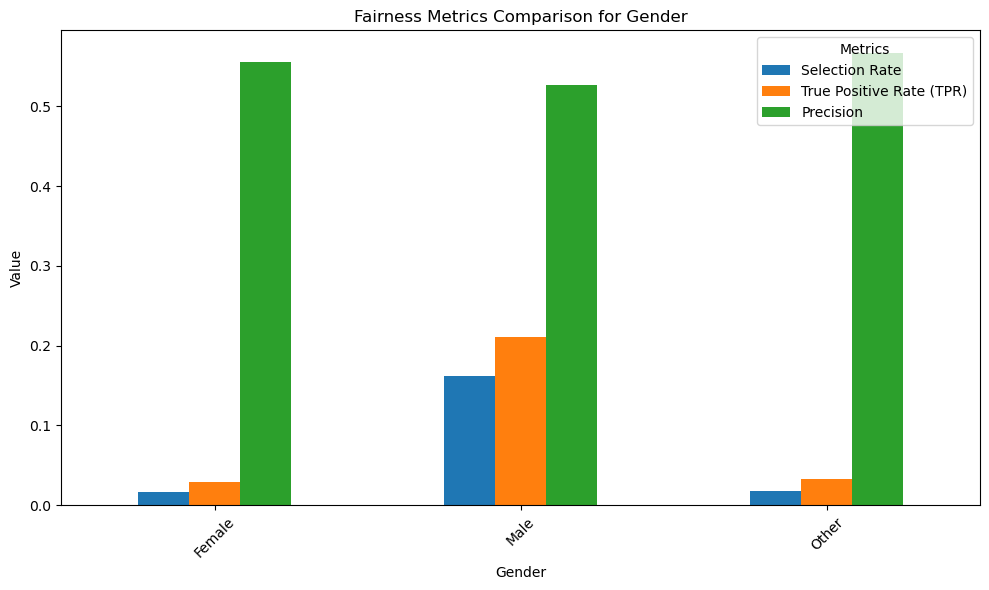

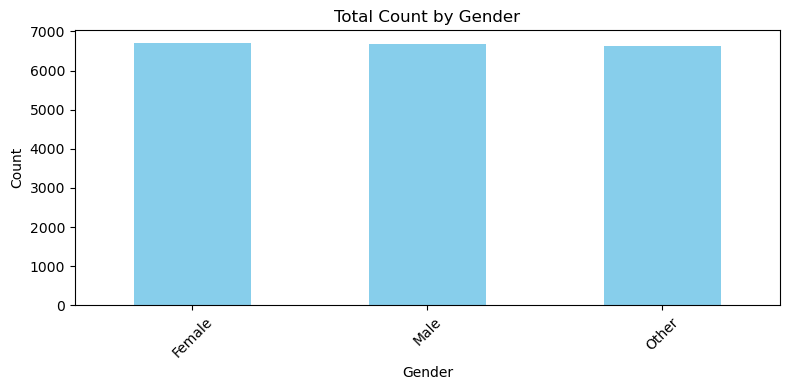


Available categories:
- Gender
- Age Group
- Education Level
- Experience Group
- Test Score Group

To view other categories, run: display_category_metrics("Category Name")


In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Load fairness metrics from JSON file
try:
    with open("fairness_metrics.json") as file:
        fairness_data = json.load(file)
except FileNotFoundError:
    # If the file doesn't exist, use the data from your output
    fairness_data = {
        "Gender": {
            "Female": {"Selection Rate": 0.0161, "True Positive Rate (TPR)": 0.0295, "Precision": 0.5556, "Total": 6695},
            "Male": {"Selection Rate": 0.1624, "True Positive Rate (TPR)": 0.2112, "Precision": 0.5263, "Total": 6682},
            "Other": {"Selection Rate": 0.0181, "True Positive Rate (TPR)": 0.0324, "Precision": 0.5667, "Total": 6623}
        }
    }

# Function to display metrics for a selected category
def display_category_metrics(category_name):
    if category_name not in fairness_data:
        print(f"Category '{category_name}' not found in data")
        return
    
    # Convert to DataFrame for better display
    category_data = fairness_data[category_name]
    df = pd.DataFrame.from_dict(category_data, orient='index')
    
    # Display as table
    display(HTML(f"<h3>Fairness Metrics for {category_name}</h3>"))
    display(df)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Plot metrics (excluding Total which is on a different scale)
    metrics_df = df.drop('Total', axis=1)
    
    # Bar chart
    ax = metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Fairness Metrics Comparison for {category_name}')
    plt.ylabel('Value')
    plt.xlabel(category_name)
    plt.xticks(rotation=45)
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()
    
    # Display totals separately
    plt.figure(figsize=(8, 4))
    df['Total'].plot(kind='bar', color='skyblue')
    plt.title(f'Total Count by {category_name}')
    plt.ylabel('Count')
    plt.xlabel(category_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display metrics for Gender category
display_category_metrics("Gender")

# Print available categories
print("\nAvailable categories:")
for category in fairness_data.keys():
    print(f"- {category}")
print("\nTo view other categories, run: display_category_metrics(\"Category Name\")")

,Selection Rate,True Positive Rate (TPR),Precision,Total
Bachelor,0.1430,0.1948,0.5440,3973
Diploma,0.0162,0.0259,0.4925,4133
High School,0.0317,0.0466,0.4286,3980
Master,0.1311,0.1748,0.5588,3958
PhD,0.0083,0.0113,0.3939,3956


<Figure size 1200x600 with 0 Axes>

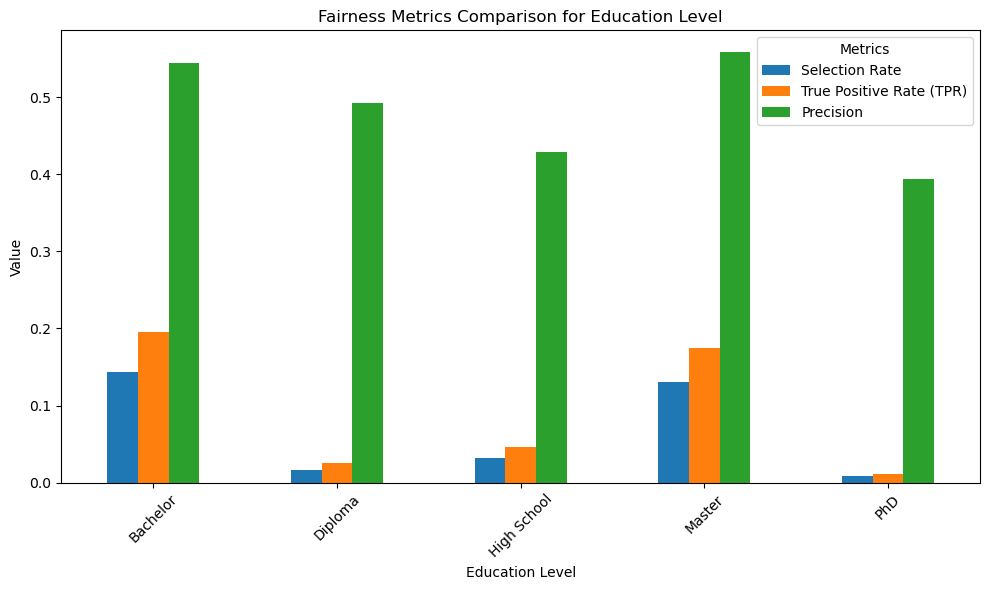

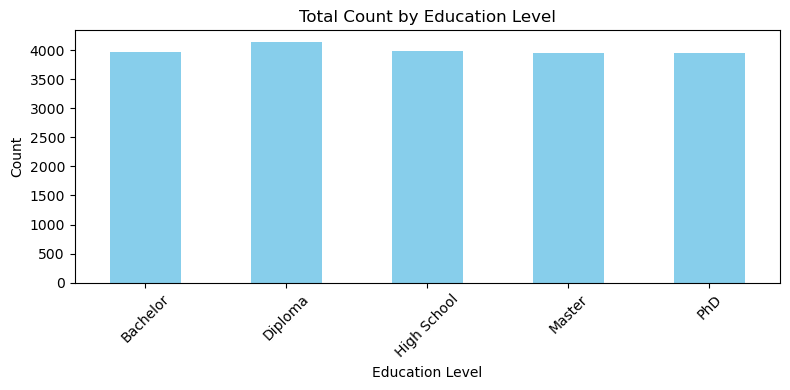

In [21]:
display_category_metrics("Education Level")

,Selection Rate,True Positive Rate (TPR),Precision,Total
Low,0.0667,0.0989,0.5079,6645
Medium,0.0570,0.0912,0.5381,6685
High,0.0733,0.1164,0.5501,6670


<Figure size 1200x600 with 0 Axes>

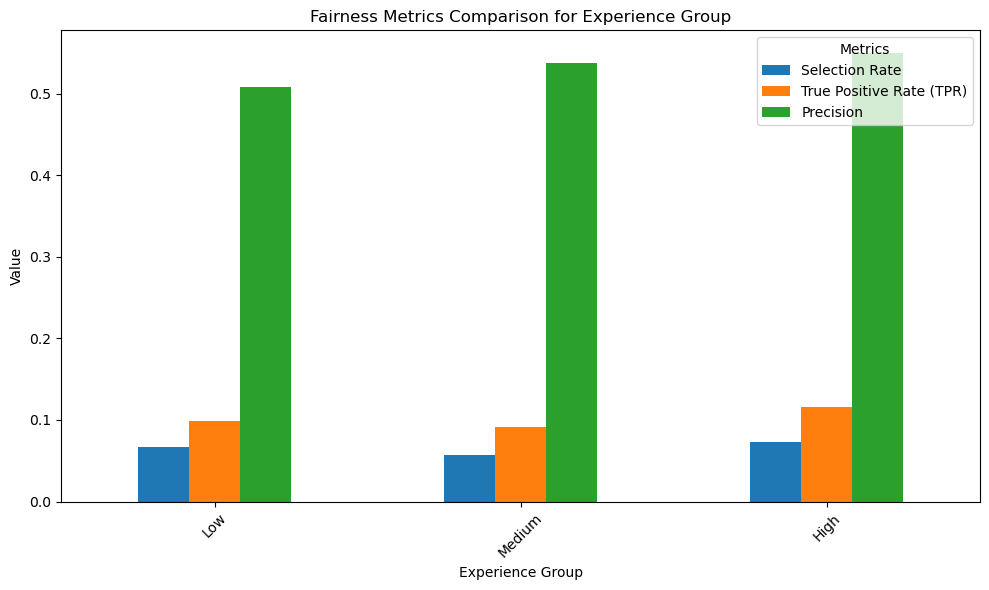

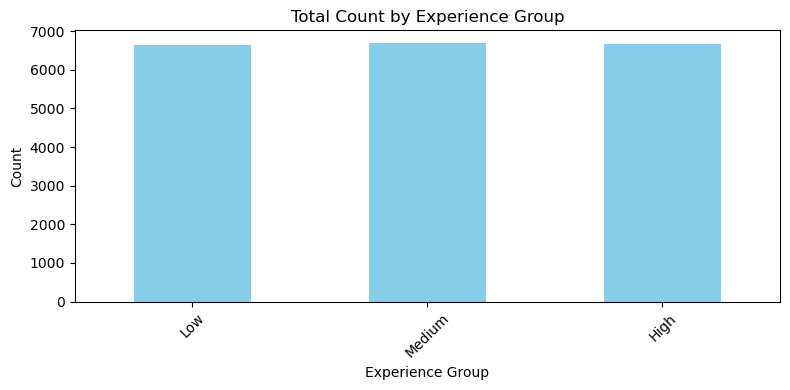

In [20]:
display_category_metrics("Experience Group")

,Selection Rate,True Positive Rate (TPR),Precision,Total
Low,0.0210,0.0354,0.5108,6626
Medium,0.0367,0.0635,0.5633,6681
High,0.1388,0.1842,0.5274,6693


<Figure size 1200x600 with 0 Axes>

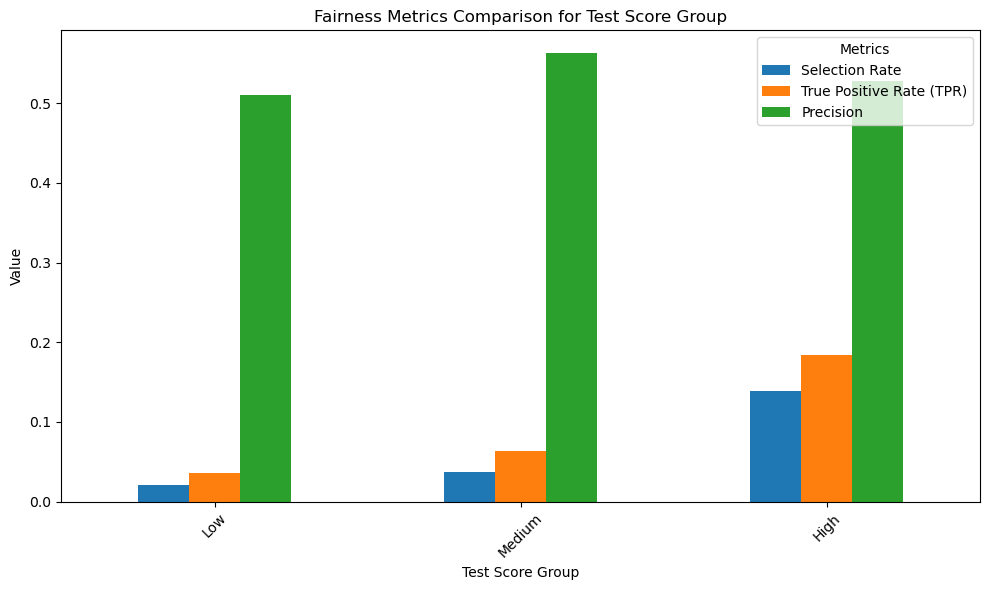

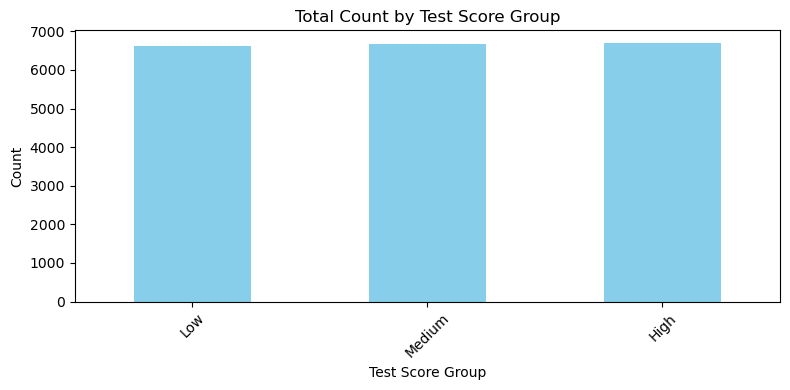

In [22]:
display_category_metrics("Test Score Group")

,Selection Rate,True Positive Rate (TPR),Precision,Total
20-30,0.0000,0.0000,0.0000,0
31-40,0.0000,0.0000,0.0000,0
41-50,0.1788,0.2322,0.5343,3338


<Figure size 1200x600 with 0 Axes>

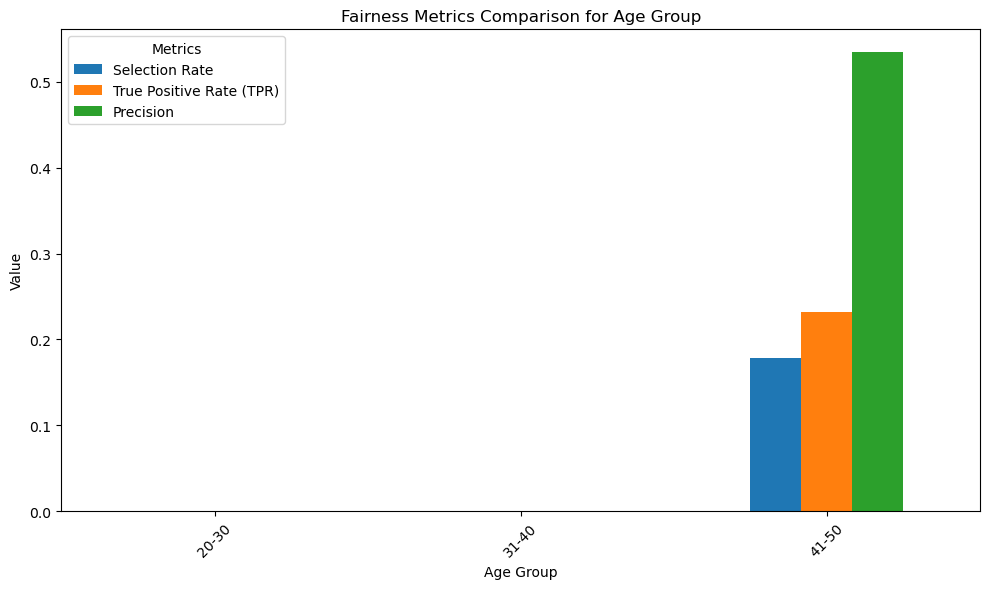

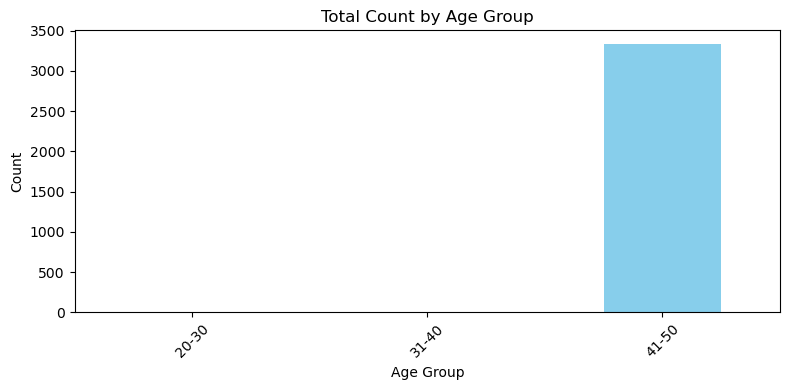

In [24]:
display_category_metrics("Age Group")